# PHY294 Franck-Hertz Experiment
### This notebook will plot the experimental data, find the line of best fit, and calculate goodness of fit criterion

#### Imports

In [8]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.optimize as optimize

#### Read in data to pandas df

In [4]:
file_paths = glob.glob('/Users/lucaschoi/Documents/GitHub/PHY294-Franck-Hertz/data/*.csv')
dataframes = {}
E2_voltages = []

for path in file_paths:
    if 'old' not in path:
        voltage = path.split('/')[-1].replace('.csv', '')
        data = pd.read_csv(path)
        dataframes[float(voltage)] = data
        E2_voltages.append(float(voltage))

E2_voltages = sorted(E2_voltages)

### Plot the different trials

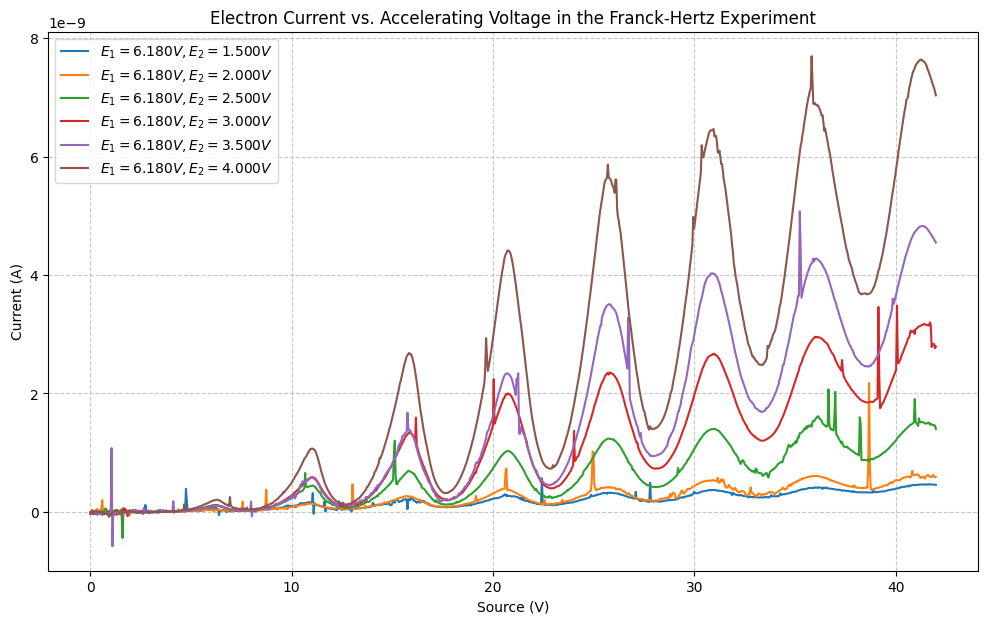

In [ ]:
plt.figure(figsize=(12, 7))
for voltage in E2_voltages:

    data = dataframes[voltage]
    plt.plot(data['CH2 Voltage'], data['CH1 Current'], label=f'$E_1= 6.180 V, E_2 = {voltage:.3f} V$')

plt.xlabel('Source (V)')
plt.ylabel('Current (A)')
plt.title('Electron Current vs. Accelerating Voltage in the Franck-Hertz Experiment')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### From here forward, we choose to use the $E_2 = 4.000V$ data since the peaks are the best defined

### Find peaks

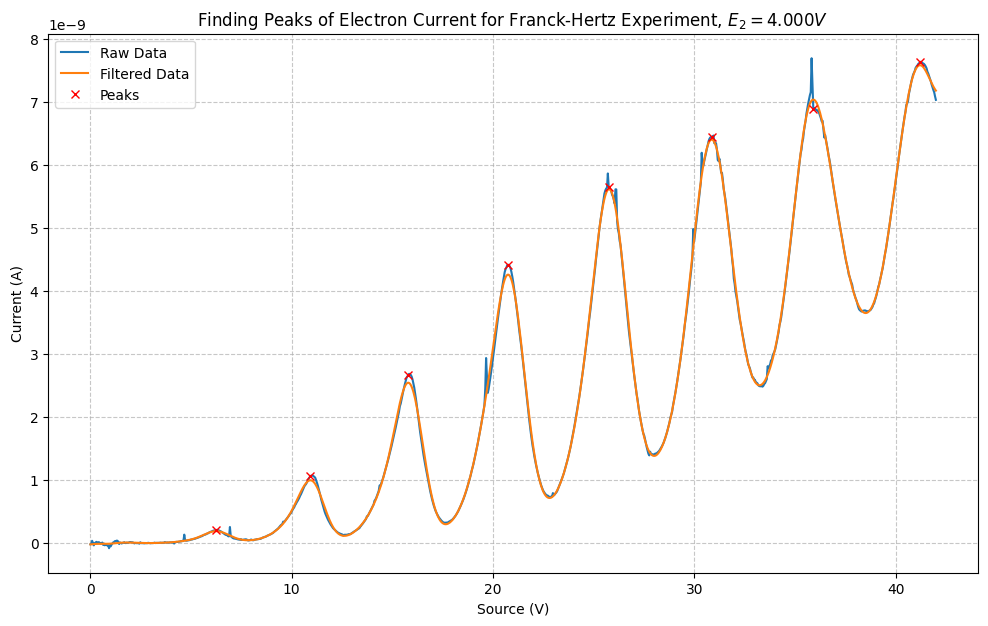

[149 260 376 494 613 735 855 981]


In [53]:
x = dataframes[4.0]['CH2 Voltage']
y = dataframes[4.0]['CH1 Current']
dx = 0.0005
dy = 0.05 * 10**-13

# apply a bandpass filter
b, a = signal.butter(3, 0.05)
y_filtered = signal.filtfilt(b, a, y)

peaks, _ = signal.find_peaks(y_filtered, height= 1 * 10**-11)

plt.figure(figsize=(12, 7))
plt.plot(x, y, label='Raw Data')
plt.plot(x, y_filtered, label='Filtered Data')
plt.plot(x[peaks], y[peaks], 'rx', label='Peaks')
plt.xlabel('Source (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Finding Peaks of Electron Current for Franck-Hertz Experiment, $E_2 = 4.000V$ ')
plt.show()
print(peaks)



### Fit the peaks

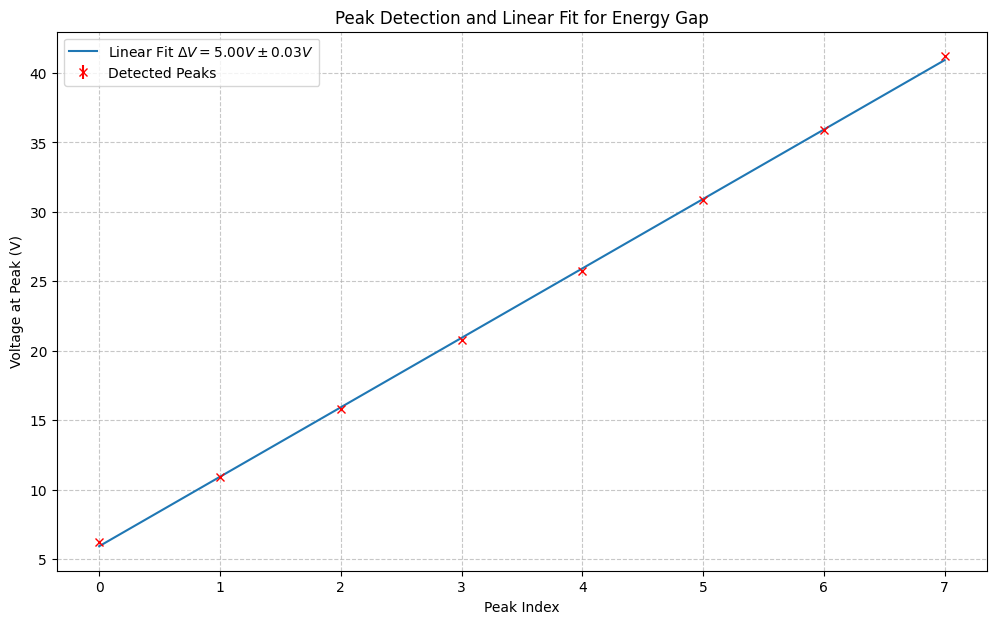

R^2: 0.9997413082447364
Reduced Chi Squared: 180950.00000000067


In [76]:
peak_voltages = dataframes[4.0]['CH2 Voltage'][peaks]
peak_index = [i for i in range(len(peaks))]
Verr = 0.0005

def linear(x, m, b):
    return m * x + b

popt, pcov = optimize.curve_fit(linear, peak_index, peak_voltages)
m, b = popt

puncert = np.sqrt(np.diagonal(pcov))  
V_unc = puncert[0]
b_unc = puncert[1]  

plt.figure(figsize=(12, 7))
plt.errorbar(peak_index, peak_voltages, yerr=Verr, fmt='rx', label='Detected Peaks')
plt.plot(peak_index, linear(np.array(peak_index), m, b), label=f'Linear Fit $\Delta V = {m:.2f}V \pm {V_unc:.2f}V$')
plt.xlabel('Peak Index')
plt.ylabel('Voltage at Peak (V)')
plt.legend()
plt.title('Peak Detection and Linear Fit for Energy Gap')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()





y_fit = np.array(peak_index) * m + b
residuals = np.array(peak_voltages) - y_fit
ss_res = sum(residuals**2)
y_mean = sum(peak_voltages) / len(peak_voltages)
ss_tot = sum((peak_voltages - y_mean)**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R^2: {r_squared}')

numerator = residuals**2
denominator = Verr**2
frac = numerator/denominator
chi_squared = sum(frac)
reduced_chi_squared = chi_squared / (len(peak_index) - 2)
print(f'Reduced Chi Squared: {reduced_chi_squared}')



### Fit the curve



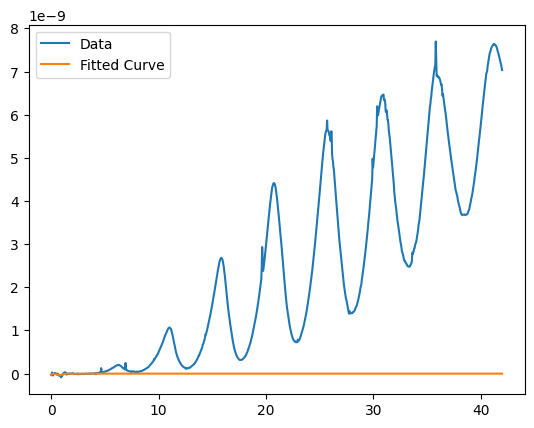

[-1.02619355e-10  2.44617188e+00 -5.92978476e-01  1.34279255e+00]
[[ 8.11899623e-17  2.88585810e-07 -1.31744471e-07 -7.91714222e-07]
 [ 2.88585810e-07  2.55988994e+03 -9.92184247e+02 -2.78234451e+03]
 [-1.31744471e-07 -9.92184247e+02  6.21098639e+02  1.35509293e+03]
 [-7.91714222e-07 -2.78234451e+03  1.35509293e+03  8.80555762e+03]]


In [17]:
x = dataframes[4.0]['CH2 Voltage']
y = dataframes[4.0]['CH1 Current']

def fit(x, a, b, c, d):
    return a * np.sin(b * x + c) ** 2 * (np.exp(-d * x))

popt, pcov = optimize.curve_fit(fit, x, y, p0=[1, 1, 1, 0.5])
plt.plot(x, y, label='Data')
plt.plot(x, fit(x, *popt), label='Fitted Curve')
plt.legend()
plt.show()
print(popt)
print(pcov)